# HDS5210-2021 Final Project
### by Xiaobo Quan

Patient satisfaction is an important healthcare outcome. Many studies have been conducted around patient satisfaction. CMS uses HCAPHS scores to measure and compare patient satisfaction in different healthcare facilities. However, it is not clear how patient satisfaction is correlated with other outcome or factors.  

The purpose of the project was to examine:
- Whether there are differences between metropolitan areas in terms of patient overall satisfaction;
- Whether the overall satisfaction indicators are correlated with hospital utilization as measured by occupancy rate, revenue per bed, and length of stay; and
- Whether the satisfaction scores on individual patient experience components (e.g., communication) are correlated with the overall satisfaction and willingness to recommend

The findings would be useful for hospitals in making efforts to improve HCAHPS scores.

## 1. Data retrieval & manipulation

### 1-1. Data sources

The following data were retrieved:
- Patient satisfaction data for individual hospitals were retrieved from CMS (cvs format): https://data.cms.gov/provider-data/sites/default/files/resources/b815c061b038a789ce9427e52e9933ab_1616702714/HCAHPS-Hospital.csv
- Zip codes in top five metropolitan areas in the U.S. (html format) were retrieved from: https://www.bestplaces.net/
- Utilization data of MO hospitals including # of beds, discharges, patient days, and gross revenue stored as a local file in xlsx format (source: American Hospital Directory)

### 1-2. HCAHPS data

First, the CMS HCAHPS data for individual hospitals in a csv file was downloaded and read in as data frame. After examining the data frame, it was determined to focus on the linear mean scores for the overall satisfaction rating, willingness to recommend, and ratings on eight aspects of healthcare services including nurse communication, doctor communication, communication about medicines, care transition, discharge information, staff responsiveness, quietness, and cleanliness. These linear mean scores reflect adjustments to the raw scores due to the effects of patient mix and survey mode. Then, a long-to-wide pivoting transformation was performed so that each satisfaction score was included in one column. Next, the data in these columns were transformed to numeric to prepare for statistical analyses. Finally, the data frame was sliced to create a data frame that included only hospitals in Missouri (to be combined with the utilization data which only contained hospitals for Missouri).

In [1]:
# Read in HCAHPS data file from the website
import pandas as pd
hcahps = pd.read_csv('https://data.cms.gov/provider-data/sites/default/files/resources/b815c061b038a789ce9427e52e9933ab_1616702714/HCAHPS-Hospital.csv', na_values='Not Available')

/opt/tljh/user/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (12,14,17,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Exclude measures other than HCAHPS linear mean scores - 
# which reflect CMS adjustments for the effects of patient mix and survey mode
hcahps_scores = hcahps[hcahps['HCAHPS Answer Description'].str[-17:]=='linear mean score']

In [3]:
# Long to wide pivoting transformation
index_list= ['Facility ID', 'Facility Name', 'Address', 'City','State','ZIP Code', 'Number of Completed Surveys', 'Survey Response Rate Percent', 'Start Date', 'End Date']
hcahps_scores_wide = hcahps_scores.pivot(index=index_list, columns='HCAHPS Question', values='HCAHPS Linear Mean Value')
hcahps_scores_all = hcahps_scores_wide.reset_index()

In [4]:
# Tranfer columns with scores to numeric
column_list = hcahps_scores_all.columns
for col in column_list:
    if col[-5:] == 'score':
        hcahps_scores_all[col] = pd.to_numeric(hcahps_scores_all[col])

In [5]:
# Set index to Facility ID
hcahps_scores_all.set_index('Facility ID')

HCAHPS Question                        Facility Name  \
Facility ID                                            
010001               SOUTHEAST HEALTH MEDICAL CENTER   
010005                      MARSHALL MEDICAL CENTERS   
010006                  NORTH ALABAMA MEDICAL CENTER   
010007                      MIZELL MEMORIAL HOSPITAL   
010008                   CRENSHAW COMMUNITY HOSPITAL   
...                                              ...   
670138           PARK AMBULATORY SURGERY CENTER, LLC   
670143                       ASCENSION SETON BASTROP   
670259                              CAPROCK HOSPITAL   
670260                  TEXAS HEALTH HOSPITAL FRISCO   
670266                     TOWNSEN MEMORIAL HOSPITAL   

HCAHPS Question                      Address      City State  ZIP Code  \
Facility ID                                                              
010001                1108 ROSS CLARK CIRCLE    DOTHAN    AL     36301   
010005            2505 U S HIGHWAY 431 NORTH      BOAZ    AL     35957   
010006                   1701 VETERANS DRIVE  FLORENCE    AL     35630   
010007                         702 N MAIN ST       OPP    AL     36467   
010008                   101 HOSPITAL CIRCLE   LUVERNE    AL     36049   
...                                      ...       ...   ...       ...   
670138           5055 W PARK BLVD, SUITE 800     PLANO    TX     75093   
670143                      630 HIGWAY 71 W,   BASTROP    TX     78602   
670259                   3134 BRIARCRESRT DR     BRYAN    TX     77802   
670260                12400 N DALLAS PARKWAY    FRISCO    TX     75033   
670266                 1475 FM 1960 BYPASS E    HUMBLE    TX     77338   

HCAHPS Question  Number of Completed Surveys  Survey Response Rate Percent  \
Facility ID                                                                  
010001                                 507.0                          21.0   
010005                                 568.0                          30.0   
010006                                1136.0                          23.0   
010007                                 179.0                          27.0   
010008                                  46.0                          25.0   
...                                      ...                           ...   
670138                                   NaN                           NaN   
670143                                   NaN                           NaN   
670259                                   NaN                           NaN   
670260                                   NaN                           NaN   
670266                                   NaN                           NaN   

HCAHPS Question  Start Date    End Date  Care transition - linear mean score  \
Facility ID                                                                    
010001           01/01/2019  12/31/2019                                 82.0   
010005           01/01/2019  12/31/2019                                 81.0   
010006           01/01/2019  12/31/2019                                 80.0   
010007           01/01/2019  12/31/2019                                 83.0   
010008           01/01/2019  12/31/2019                                  NaN   
...                     ...         ...                                  ...   
670138           01/01/2019  12/31/2019                                  NaN   
670143           01/01/2019  12/31/2019                                  NaN   
670259           01/01/2019  12/31/2019                                  NaN   
670260           01/01/2019  12/31/2019                                  NaN   
670266           01/01/2019  12/31/2019                                  NaN   

HCAHPS Question  Cleanliness - linear mean score  \
Facility ID                                        
010001                                      87.0   
010005                                      85.0   
010006                                      

In [6]:
# Narrow down to hospitals in Missouri
hcahps_scores_mo = hcahps_scores_all.loc[(hcahps_scores_all['State']=='MO')]

### 1-3. Merge HCAHPS data with zip code data for the top five metropolitan areas in the U.S.

The zip codes in each of the top five metropolitan areas in the U.S. were read from the relevant webpages at https://www.bestplaces.net/ and stored in five individual lists. Then a new 'metro' column was created in the HCAHPS DataFrame to indicate the metro areas where the hospitals was located. 

In [7]:
from bs4 import BeautifulSoup
import requests
headers = { "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36" }

# Identify the webpage for a particular metro area
ny_link = 'https://www.bestplaces.net/find/zip.aspx?msa=35620&st=ny'
la_link = 'https://www.bestplaces.net/find/zip.aspx?msa=31080&st=ca'
chi_link = 'https://www.bestplaces.net/find/zip.aspx?msa=16980&st=il'
dfa_link = 'https://www.bestplaces.net/find/zip.aspx?msa=19100&st=tx'
htx_link = 'https://www.bestplaces.net/find/zip.aspx?msa=26420&st=tx'

In [8]:
# Define a function to get a list of zip codes in a metro area
def getzips(weblink):
    """
    This function takes the address of a webpage from www.bestplaces.net that shows cities and zip codes in a metro area as a string. 
    Then it returns a list of zip codes in the metro area.
    """
    response = requests.get(weblink, headers=headers, verify=False)
    soup = BeautifulSoup(response.text, 'html.parser')
    div = soup.find_all('div', {"class":"col-md-4"})
    zip_list=[]
    for col in div:
        for cell in col.find_all('a'):
            zip_list.append(cell.text[:5])
    return zip_list

In [9]:
# Obtain zip code list for each of the top five metro areas by using the getzips function
ny_zip_list = getzips(ny_link)
la_zip_list = getzips(la_link)
chi_zip_list = getzips(chi_link)
dfa_zip_list = getzips(dfa_link)
htx_zip_list = getzips(htx_link)

/opt/tljh/user/lib/python3.6/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.bestplaces.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/opt/tljh/user/lib/python3.6/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.bestplaces.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/opt/tljh/user/lib/python3.6/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.bestplaces.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/opt/tljh/user/lib/pyt

In [10]:
# Merge HCAHPS data with zp code data
# Create a 'Metro' column based on a hospital's zip code
hcahps_scores_all.loc[hcahps_scores_all['ZIP Code'].isin(ny_zip_list), 'Metro'] = 'NY'
hcahps_scores_all.loc[hcahps_scores_all['ZIP Code'].isin(la_zip_list), 'Metro'] = 'LA'
hcahps_scores_all.loc[hcahps_scores_all['ZIP Code'].isin(chi_zip_list), 'Metro'] = 'CHI'
hcahps_scores_all.loc[hcahps_scores_all['ZIP Code'].isin(dfa_zip_list), 'Metro'] = 'DFA'
hcahps_scores_all.loc[hcahps_scores_all['ZIP Code'].isin(htx_zip_list), 'Metro'] = 'HTX'

In [11]:
# Check # of hospitals in each metro area
hcahps_scores_all['Metro'].value_counts()

LA     103
DFA     84
NY      81
CHI     76
HTX     58
Name: Metro, dtype: int64

### 1-4. Merge HCAHPS data and hospital utlization data for MO hospitals

The hospital utilization data were read from the local xlsx file and combined with the HCAHPS data. The unique CMS certification numbers (stored in the 'Facility ID' column) were used to join the two DataFrames.

In [12]:
# Read in the hospital utlization data file stored locally
utilization_mo = pd.read_excel('mo_hospital_utilization.xlsx', na_values='0')

In [13]:
# Transfer columns with scores to numeric
column_list = utilization_mo.columns
for col in column_list[3:]:
    utilization_mo[col] = pd.to_numeric(utilization_mo[col])

In [14]:
# Merge DataFrames on the 'Facility ID' column
hcahps_utilization_mo = pd.merge(hcahps_scores_mo, utilization_mo, how='left', on=['Facility ID'])

In [15]:
# Create a new 'Occupancy' column to show the # of days a bed is occupied in a year
hcahps_utilization_mo['Occupancy'] = hcahps_utilization_mo.apply(lambda row: row.Patient_days / row.Beds, axis=1)

In [16]:
# Create a new 'LOS' column to show the # of days per stay
hcahps_utilization_mo['LOS'] = hcahps_utilization_mo.apply(lambda row: row.Patient_days / row.Discharges, axis=1)

In [17]:
# Create a new 'Revenue_per_bed' column to show the total annual revenue (in thounsands) per stay
hcahps_utilization_mo['Revenue_per_bed'] = hcahps_utilization_mo.apply(lambda row: row.Patient_revenue / row.Beds, axis=1)

In [18]:
# Check the new merged DataFrame
hcahps_utilization_mo.head()

Facility ID                     Facility Name             Address  \
0      260001             MERCY HOSPITAL JOPLIN       100 MERCY WAY   
1      260004  COOPER COUNTY COMMUNITY HOSPITAL         17651 B HWY   
2      260005       SSM ST JOSEPH HEALTH CENTER  300 1ST CAPITOL DR   
3      260006     MOSAIC LIFE CARE AT ST JOSEPH  5325 FARAON STREET   
4      260009   BOTHWELL REGIONAL HEALTH CENTER       601 E 14TH ST   

          City_x State  ZIP Code  Number of Completed Surveys  \
0         JOPLIN    MO     64804                       1525.0   
1      BOONVILLE    MO     65233                        105.0   
2  SAINT CHARLES    MO     63301                        433.0   
3   SAINT JOSEPH    MO     64506                        450.0   
4        SEDALIA    MO     65301                        399.0   

   Survey Response Rate Percent  Start Date    End Date  ...  \
0                          33.0  01/01/2019  12/31/2019  ...   
1                          30.0  01/01/2019  12/31/2019  ...   
2                          26.0  01/01/2019  12/31/2019  ...   
3                          21.0  01/01/2019  12/31/2019  ...   
4                          24.0  01/01/2019  12/31/2019  ...   

   Staff responsiveness - linear mean score  \
0                                      84.0   
1                                      90.0   
2                                      81.0   
3                                      82.0   
4                                      87.0   

                                     Facility name         City_y   Beds  \
0                            Mercy Hospital Joplin         Joplin  241.0   
1                                              NaN            NaN    NaN   
2  SSM  Health Saint Joseph Hospital-Saint Charles  Saint Charles  406.0   
3    Mosaic Life Care at St. Joseph Medical Center   Saint Joseph  352.0   
4                  Bothwell Regional Health Center        Sedalia  108.0   

   Discharges  Patient_days  Patient_revenue   Occupancy       LOS  \
0     12057.0       54747.0         994042.0  227.165975  4.540682   
1         NaN           NaN              NaN         NaN       NaN   
2     11819.0       55144.0         800174.0  135.822660  4.665708   
3     21465.0       72356.0        1299870.0  205.556818  3.370883   
4      3621.0       13811.0         353186.0  127.879630  3.814140   

   Revenue_per_bed  
0      4124.655602  
1              NaN  
2      1970.871921  
3      3692.812500  
4      3270.240741  

[5 rows x 29 columns]

## 2. Compare metropolitan areas in terms of hospital patient's overall satisfaction

Descriptive statistics and plots (box, violin, KDE plots) were used to explore differences between metro areas in terms of the overall satisfaction score. ANOVA and multiple comparisons were conducted to find the significant differences.

Findings:
- There were significant differences between metro areas.
- Dallas and Houston metro areas were associated with highest scores, followed by Chicago and Los Angeles. Hospitals in New York area were rated the lowest.

### 2-1. Visualization & descriptive statistics

In [19]:
# Descriptive statistics
hcahps_scores_all['Overall hospital rating - linear mean score'].groupby(hcahps_scores_all['Metro']).agg(['count','min','mean','median','max', 'std','var'])

count   min       mean  median   max       std        var
Metro                                                           
CHI       65  67.0  86.661538    87.0  95.0  4.867870  23.696154
DFA       70  79.0  89.842857    90.0  96.0  3.573800  12.772050
HTX       40  83.0  89.125000    89.0  95.0  2.954245   8.727564
LA        90  76.0  86.744444    87.0  95.0  4.012792  16.102497
NY        75  77.0  84.933333    85.0  95.0  4.262766  18.171171

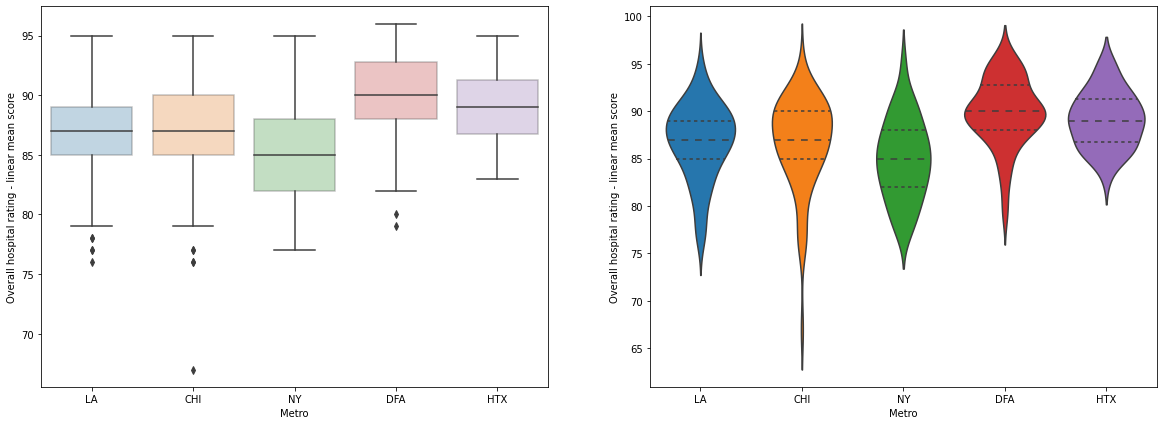

In [20]:
# Box plot & violin plot
from matplotlib import pyplot
import seaborn as sns
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(20,7))
sns.boxplot(ax = ax1, x = 'Metro', y = 'Overall hospital rating - linear mean score', data = hcahps_scores_all, boxprops=dict(alpha=.3))
sns.violinplot(ax = ax2, x = 'Metro', y = 'Overall hospital rating - linear mean score', data = hcahps_scores_all, inner="quartiles", saturation=0.9)

In [21]:
# Kernel density estimate (KDE) plot
hcahps_scores_all.groupby('Metro')['Overall hospital rating - linear mean score'].plot.kde(
    xlim=(65,100),
    legend=True,
    figsize=(10,7))

Metro
CHI    AxesSubplot(0.125,0.125;0.775x0.755)
DFA    AxesSubplot(0.125,0.125;0.775x0.755)
HTX    AxesSubplot(0.125,0.125;0.775x0.755)
LA     AxesSubplot(0.125,0.125;0.775x0.755)
NY     AxesSubplot(0.125,0.125;0.775x0.755)
Name: Overall hospital rating - linear mean score, dtype: object

### 2-2. Statistical tests

In [22]:
# ANOVA test
import scipy.stats as stats
stats.f_oneway(hcahps_scores_all.dropna()['Overall hospital rating - linear mean score'][hcahps_scores_all['Metro'] == 'NY'],
               hcahps_scores_all.dropna()['Overall hospital rating - linear mean score'][hcahps_scores_all['Metro'] == 'LA'],
               hcahps_scores_all.dropna()['Overall hospital rating - linear mean score'][hcahps_scores_all['Metro'] == 'CHI'],
               hcahps_scores_all.dropna()['Overall hospital rating - linear mean score'][hcahps_scores_all['Metro'] == 'DFA'],
               hcahps_scores_all.dropna()['Overall hospital rating - linear mean score'][hcahps_scores_all['Metro'] == 'HTX'])

F_onewayResult(statistic=16.082854061601953, pvalue=4.661820236804548e-12)

In [23]:
# Multiple comparisons - Tukey HSD 
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(hcahps_scores_all.dropna()['Overall hospital rating - linear mean score'], hcahps_scores_all.dropna()['Metro'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [24]:
# Multiple comparisons - Holm-Bonferroni
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "Holm")
tbl

<class 'statsmodels.iolib.table.SimpleTable'>

## 3. Relationships between patient satisfaction and hospital utilization outcomes

Correlational analyses were conducted to examine the probable relationships between satisfaction indicators and hospital utilization outcomes including occupancy rate, total patient revenue, patient revenue per bed, and length of stay.

Finding:
- Patient's willingness to recommend was significantly correlated with hospital bed occupancy rate and patient revenue. 
- This confirmed that patient satisfaction was an important outcome that had significant financial consequences.

### 3-1. Visualization & descriptive statistics

In [25]:
# Descritive statistics of the satisfaction and utilization variables
hcahps_utilization_mo = hcahps_utilization_mo[['Facility ID', 'Overall hospital rating - linear mean score', 'Recommend hospital - linear mean score',
                                              'Beds', 'Discharges', 'Patient_days', 'Patient_revenue', 'Occupancy', 'LOS', 'Revenue_per_bed']]
hcahps_utilization_mo.describe()

Overall hospital rating - linear mean score  \
count                                    86.000000   
mean                                     88.511628   
std                                       2.505261   
min                                      82.000000   
25%                                      87.000000   
50%                                      89.000000   
75%                                      90.000000   
max                                      95.000000   

       Recommend hospital - linear mean score         Beds    Discharges  \
count                               86.000000    68.000000     68.000000   
mean                                88.011628   244.426471   9888.911765   
std                                  3.455581   236.281095  10184.798360   
min                                 81.000000    37.000000    106.000000   
25%                                 85.000000    71.750000   2808.000000   
50%                                 88.500000   167.000000   5787.500000   
75%                                 91.000000   336.500000  13191.750000   
max                                 94.000000  1331.000000  52862.000000   

        Patient_days  Patient_revenue   Occupancy        LOS  Revenue_per_bed  
count      68.000000     6.800000e+01   68.000000  68.000000        68.000000  
mean    46711.338235     1.135674e+06  160.110519   4.136717      4476.616675  
std     56943.906784     1.257777e+06   70.234410   1.084645      2074.050595  
min       240.000000     2.803500e+04    6.486486   2.074180       445.000000  
25%      8558.000000     3.217040e+05  105.709464   3.432379      2995.400000  
50%     22653.000000     6.921570e+05  161.342428   3.838930      4367.307222  
75%     64547.250000     1.615436e+06  209.283079   4.798339      5797.701929  
max    321661.000000     6.661497e+06  303.451087   7.954106      8887.690391

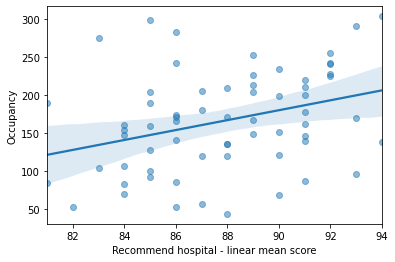

In [26]:
# Create scatter plots with fitted regression lines
import seaborn as sns
sns.regplot(x="Recommend hospital - linear mean score", y="Occupancy", data=hcahps_utilization_mo, scatter_kws={'alpha':0.5})

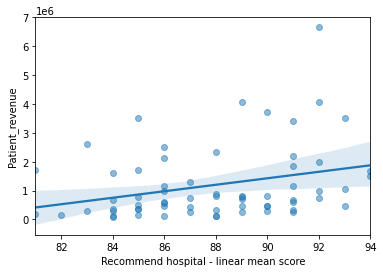

In [27]:
sns.regplot(x="Recommend hospital - linear mean score", y="Patient_revenue", data=hcahps_utilization_mo, scatter_kws={'alpha':0.5})

### 3-2. Correlation tests

In [28]:
from scipy.stats import kendalltau, pearsonr, spearmanr
def kendall_pval(x,y):
    return kendalltau(x,y)[1]
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]    
def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

In [29]:
# Define a function to calculate correlational coefficient and p-value
def corr(df, var1, var2):
    """
    The function takes a DataFrame, two strings - the names of two columns of the DataFrame; and 
    print the correlational coefficient and p-value
    """
    corr_r = df[[var1,var2]].corr(method='pearson')
    corr_p = df[[var1,var2]].corr(method=pearsonr_pval)
    print('coefficient: {}; p-value: {}'.format(round(corr_r.iloc[0,1], 4), round(corr_p.iloc[0,1], 4)))

In [30]:
# Calculate correlational coefficients and p-values
corr(hcahps_utilization_mo, 'Recommend hospital - linear mean score', 'Occupancy')
corr(hcahps_utilization_mo, 'Recommend hospital - linear mean score', 'Patient_revenue')
corr(hcahps_utilization_mo, 'Recommend hospital - linear mean score', 'Revenue_per_bed')
corr(hcahps_utilization_mo, 'Recommend hospital - linear mean score', 'LOS')

coefficient: 0.329; p-value: 0.0075
coefficient: 0.2947; p-value: 0.0172
coefficient: 0.1538; p-value: 0.2213
coefficient: 0.1758; p-value: 0.1613


In [31]:
corr(hcahps_utilization_mo, 'Overall hospital rating - linear mean score', 'Occupancy')
corr(hcahps_utilization_mo, 'Overall hospital rating - linear mean score', 'Patient_revenue')
corr(hcahps_utilization_mo, 'Overall hospital rating - linear mean score', 'Revenue_per_bed')
corr(hcahps_utilization_mo, 'Overall hospital rating - linear mean score', 'LOS')

coefficient: 0.2255; p-value: 0.0708
coefficient: 0.1903; p-value: 0.1289
coefficient: 0.148; p-value: 0.2392
coefficient: 0.035; p-value: 0.7817


## 4. Regression analysis on relative importance of patient satisfaction components

Descriptive statistics and correlations were calculated on the satisfaction scores of 8 individual patient experience components (e.g., communication) as well as the overall satisfaction. Then regression analysis with backward selection was conducted to identify relatively more important components.

Findings:
- Several patient experience components (including care transition, nurse communication, cleanliness, and quietness) were significant predictors of overall satisfaction.


### 4-1. Descriptive statistics

In [32]:
# Prepare for regression anaysis
# Remove rows with missing values 
hcahps_scores_df = hcahps_scores_all.drop(columns = 'Metro').dropna()

In [33]:
# Descriptives of all variables
hcahps_scores_df.iloc[:,-10:].describe(include='all')

HCAHPS Question  Care transition - linear mean score  \
count                                    3459.000000   
mean                                       81.872796   
std                                         2.886820   
min                                        66.000000   
25%                                        80.000000   
50%                                        82.000000   
75%                                        84.000000   
max                                        99.000000   

HCAHPS Question  Cleanliness - linear mean score  \
count                                3459.000000   
mean                                   88.053195   
std                                     3.824528   
min                                    72.000000   
25%                                    86.000000   
50%                                    88.000000   
75%                                    91.000000   
max                                   100.000000   

HCAHPS Question  Communication about medicines - linear mean score  \
count                                                  3459.000000   
mean                                                     78.908355   
std                                                       4.399312   
min                                                      53.000000   
25%                                                      76.000000   
50%                                                      79.000000   
75%                                                      82.000000   
max                                                     100.000000   

HCAHPS Question  Discharge information - linear mean score  \
count                                          3459.000000   
mean                                             87.109858   
std                                               3.671843   
min                                              63.000000   
25%                                              85.000000   
50%                                              87.000000   
75%                                              89.000000   
max                                              99.000000   

HCAHPS Question  Doctor communication - linear mean score  \
count                                         3459.000000   
mean                                            91.574443   
std                                              2.407909   
min                                             79.000000   
25%                                             90.000000   
50%                                             92.000000   
75%                                             93.000000   
max                                            100.000000   

HCAHPS Question  Nurse communication - linear mean score  \
count                                        3459.000000   
mean                                           91.678231   
std                                             2.470232   
min                                            73.000000   
25%                                            90.000000   
50%                                            92.000000   
75%                                            93.000000   
max                                           100.000000   

HCAHPS Question  Overall hospital rating - linear mean score  \
count                                            3459.000000   
mean                                               88.537149   
std                                                 3.344409   
min                                                67.000000   
25%                                                87.000000   
50%                                                89.000000   
75%                                                91.000000   
max                                                98.000000   

HCAHPS Question  Quietness - linear mean score  \
count                              3459.000000   
mean                                 82.402428   
std               

In [34]:
# Calculate correlation between variables
hcahps_scores_df.iloc[:,-10:].corr()

HCAHPS Question                                    Care transition - linear mean score  \
HCAHPS Question                                                                          
Care transition - linear mean score                                           1.000000   
Cleanliness - linear mean score                                               0.607520   
Communication about medicines - linear mean score                             0.797662   
Discharge information - linear mean score                                     0.734623   
Doctor communication - linear mean score                                      0.783856   
Nurse communication - linear mean score                                       0.823922   
Overall hospital rating - linear mean score                                   0.871065   
Quietness - linear mean score                                                 0.615164   
Recommend hospital - linear mean score                                        0.838256   
Staff responsiveness - linear mean score                                      0.752085   

HCAHPS Question                                    Cleanliness - linear mean score  \
HCAHPS Question                                                                      
Care transition - linear mean score                                       0.607520   
Cleanliness - linear mean score                                           1.000000   
Communication about medicines - linear mean score                         0.648155   
Discharge information - linear mean score                                 0.502416   
Doctor communication - linear mean score                                  0.571086   
Nurse communication - linear mean score                                   0.662768   
Overall hospital rating - linear mean score                               0.659910   
Quietness - linear mean score                                             0.564079   
Recommend hospital - linear mean score                                    0.564261   
Staff responsiveness - linear mean score                                  0.691085   

HCAHPS Question                                    Communication about medicines - linear mean score  \
HCAHPS Question                                                                                        
Care transition - linear mean score                                                         0.797662   
Cleanliness - linear mean score                                                             0.648155   
Communication about medicines - linear mean score                                           1.000000   
Discharge information - linear mean score                                                   0.660695   
Doctor communication - linear mean score                                                    0.707844   
Nurse communication - linear mean score                                                     0.768297   
Overall hospital rating - linear mean score                                                 0.757328   
Quietness - linear mean score                                                               0.584353   
Recommend hospital - linear mean score                                                      0.679535   
Staff responsiveness - linear mean score                                                    0.784956   

HCAHPS Question                                    Discharge information - linear mean score  \
HCAHPS Question                                                                                
Care transition - linear mean score                                                 0.734623   
Cleanliness - linear mean score                                                     0.502416   
Communication about medicines - linear mean score                                   0.660695   
Discharge information - linear mean score                                           1.000000   
Doctor communication - linear mean score                     

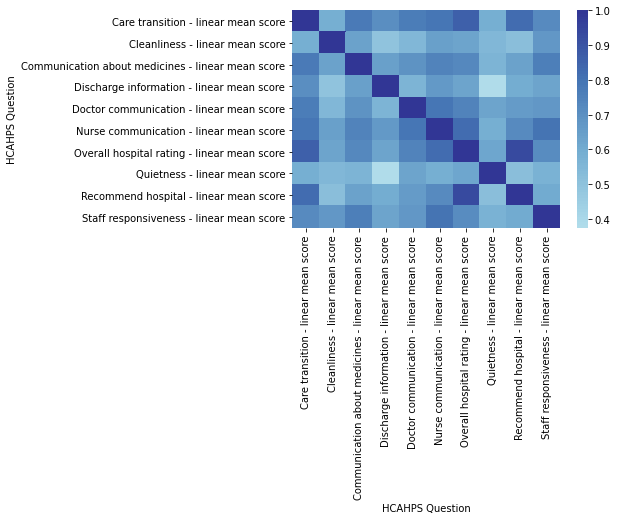

In [35]:
# Visualize the correlations between variables
sns.heatmap(hcahps_scores_df.iloc[:,-10:].corr('spearman'), center=0, cmap='RdYlBu')

### 4-2. Regression analysis

In [36]:
# Regressional analysis with backward selection
import numpy as np
import statsmodels.api as sm
x_list = ['Care transition - linear mean score',
          'Cleanliness - linear mean score',
          'Communication about medicines - linear mean score',
          'Discharge information - linear mean score',
          'Doctor communication - linear mean score',
          'Nurse communication - linear mean score',
          'Quietness - linear mean score',
          'Staff responsiveness - linear mean score']
y = hcahps_scores_df['Overall hospital rating - linear mean score']
r2adjusted_dict = {}
alpha = 0.05
max_pvalue = 1
while max_pvalue > alpha:
    x = hcahps_scores_df[x_list]
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    r2adjusted_dict[str(x_list)] = round(model.rsquared_adj, 5)
    p_values = list(model.pvalues)
    max_pvalue = max(p_values)
    del x_list[p_values.index(max_pvalue) - 1]
final_model = model

In [37]:
# Examine the model with selected variables
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     Overall hospital rating - linear mean score   R-squared:                       0.821
Model:                                                     OLS   Adj. R-squared:                  0.821
Method:                                          Least Squares   F-statistic:                     3968.
Date:                                         Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                                                 15:31:56   Log-Likelihood:                -6105.7
No. Observations:                                         3459   AIC:                         1.222e+04
Df Residuals:                                             3454   BIC:                         1.225e+04
Df Model:                                                    4                                         
Covariance Type:                                     nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                     -10.7022      0.919    -11.651      0.000     -12.503      -8.901
Care transition - linear mean score         0.5753      0.015     37.835      0.000       0.546       0.605
Cleanliness - linear mean score             0.0890      0.009     10.181      0.000       0.072       0.106
Nurse communication - linear mean score     0.4413      0.019     23.669      0.000       0.405       0.478
Quietness - linear mean score               0.0466      0.006      7.389      0.000       0.034       0.059
==============================================================================
Omnibus:                      315.592   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              764.073
Skew:                          -0.541   Prob(JB):                    1.21e-166
Kurtosis:                       5.032   Cond. No.                     6.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
# Check models in the backward slection process & the adjusted R-squared values  
r2adjusted_dict

{"['Care transition - linear mean score', 'Cleanliness - linear mean score', 'Communication about medicines - linear mean score', 'Discharge information - linear mean score', 'Doctor communication - linear mean score', 'Nurse communication - linear mean score', 'Quietness - linear mean score', 'Staff responsiveness - linear mean score']": 0.82099,
 "['Care transition - linear mean score', 'Cleanliness - linear mean score', 'Communication about medicines - linear mean score', 'Discharge information - linear mean score', 'Doctor communication - linear mean score', 'Nurse communication - linear mean score', 'Quietness - linear mean score']": 0.82102,
 "['Care transition - linear mean score', 'Cleanliness - linear mean score', 'Communication about medicines - linear mean score', 'Doctor communication - linear mean score', 'Nurse communication - linear mean score', 'Quietness - linear mean score']": 0.82106,
 "['Care transition - linear mean score', 'Cleanliness - linear mean score', 'Docto

## 3. Conclusions

Based on analyses of HCAHPS, zip codes, and hospital utilization data from the three sources, it can be concluded that:
- Significant differences exist between the metropolitan areas in terms of overall patient satisfaction. Among the top five metropolitan areas in the U.S., Dallas and Houston metro areas were associated with highest overall satisfaction scores, followed by Chicago and Los Angeles. Hospitals in New York area were rated the lowest. The root causes behind these differences need to be explored in future research.
- Based on data from Missouri hospitals, patient's willingness to recommend was significantly correlated with hospital bed occupancy rate and patient revenue. This confirmed that patient satisfaction was an important outcome that had significant financial consequences.
- Several patient experience components (including care transition, nurse communication, cleanliness, and quietness) were significant predictors of overall satisfaction. Hospitals should pay more attention to these aspects in order to improve patient overall satisfaction. 


In [39]:
%%bash
git pull
git add week13_assignment.ipynb
git add mo_hospital_utilization.xlsx
git commit -a -m "Submitting the final project"
git push

Already up to date.
[main 39dd79b] Submitting the final project
 2 files changed, 47 insertions(+), 2 deletions(-)
 create mode 100644 Final/mo_hospital_utilization.xlsx


fatal: pathspec 'week13_assignment.ipynb' did not match any files
To github.com:quanxiaobo/hds5210-2021.git
   e0a824d..39dd79b  main -> main
